# EDA
## 1. Read Data

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from category_encoders import TargetEncoder
import seaborn as sns

In [175]:
# import Telco data into a pandas data frame
df_telco = pd.read_csv('train (1) 1 (1).csv')

## 2. EDA & Data Cleaning

### Objectives: 
- understand the data 
- discover patterns and anomalies 
- check assumptions before performing further evaluations

In [176]:
# concise summary of the data frame
df_telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 20 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   state                          3000 non-null   object 
 1   account_length                 3000 non-null   int64  
 2   area_code                      3000 non-null   object 
 3   international_plan             3000 non-null   object 
 4   voice_mail_plan                3000 non-null   object 
 5   number_vmail_messages          3000 non-null   int64  
 6   total_day_minutes              3000 non-null   float64
 7   total_day_calls                3000 non-null   int64  
 8   total_day_charge               3000 non-null   float64
 9   total_eve_minutes              3000 non-null   float64
 10  total_eve_calls                3000 non-null   int64  
 11  total_eve_charge               3000 non-null   float64
 12  total_night_minutes            3000 non-null   f

INTERPRETATION:
- 20 columns, 3000 observations
- no null values
- data types: int64, float64, object
- all columns have proper data types

In [177]:
# check unique values of each column that aren't numerical
for column in df_telco.columns:
    if not (df_telco[column].dtype == 'int64' or df_telco[column].dtype == 'float64'):
        print('{} - Unique Values: {}\n'.format(column, df_telco[column].unique()))

state - Unique Values: ['HI' 'TN' 'CT' 'TX' 'NY' 'UT' 'IL' 'MI' 'AL' 'MO' 'VA' 'MS' 'KS' 'WV'
 'WY' 'CO' 'WI' 'NJ' 'NH' 'ID' 'MD' 'DC' 'MA' 'MN' 'RI' 'MT' 'OR' 'OK'
 'NV' 'GA' 'OH' 'NE' 'SD' 'ND' 'DE' 'ME' 'SC' 'AZ' 'IN' 'VT' 'FL' 'AR'
 'LA' 'NC' 'WA' 'KY' 'PA' 'NM' 'IA' 'AK' 'CA']

area_code - Unique Values: ['area_code_415' 'area_code_408' 'area_code_510']

international_plan - Unique Values: ['no' 'yes']

voice_mail_plan - Unique Values: ['no' 'yes']

payment_delay - Unique Values: ['no' 'yes']



In [178]:
# Check number of unique states
df_telco['state'].unique().size

51

INTERPRETATION:
- We have data covering all the 50 USA states, including Washington DC (federal district)
- Even so, we only have 3 area_codes, and those are located in California only => the area code data seems erroneous and can be removed

In [179]:
# Removing area_code data from data set
df_telco.drop('area_code', axis=1, inplace=True)
df_telco

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,payment_delay
0,HI,33,no,no,0,200.5,117,34.09,159.9,111,13.59,196.2,84,8.83,16.3,6,4.40,3,no
1,TN,80,yes,no,0,276.5,122,47.01,195.6,79,16.63,210.3,78,9.46,7.2,3,1.94,1,yes
2,CT,37,no,no,0,134.9,98,22.93,248.4,130,21.11,236.2,113,10.63,14.7,2,3.97,3,no
3,TN,106,no,no,0,119.2,142,20.26,228.4,139,19.41,197.9,61,8.91,8.4,9,2.27,2,no
4,TX,123,no,no,0,260.9,85,44.35,168.5,103,14.32,178.3,91,8.02,13.3,5,3.59,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,MT,10,no,no,0,183.0,103,31.11,214.8,77,18.26,206.4,73,9.29,8.7,6,2.35,2,no
2996,OR,135,no,no,0,263.8,66,44.85,251.3,116,21.36,200.1,112,9.00,8.4,2,2.27,5,yes
2997,AK,52,no,no,0,148.3,83,25.21,181.6,79,15.44,155.6,104,7.00,8.3,6,2.24,3,no
2998,TN,39,no,no,0,187.2,110,31.82,114.7,116,9.75,104.7,83,4.71,13.2,5,3.56,1,no


In [180]:
# drop all the rows that have missing values (just in case, none found in our data set)
df_telco.dropna(inplace=True)
df_telco

,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,payment_delay
0,HI,33,no,no,0,200.5,117,34.09,159.9,111,13.59,196.2,84,8.83,16.3,6,4.40,3,no
1,TN,80,yes,no,0,276.5,122,47.01,195.6,79,16.63,210.3,78,9.46,7.2,3,1.94,1,yes
2,CT,37,no,no,0,134.9,98,22.93,248.4,130,21.11,236.2,113,10.63,14.7,2,3.97,3,no
3,TN,106,no,no,0,119.2,142,20.26,228.4,139,19.41,197.9,61,8.91,8.4,9,2.27,2,no
4,TX,123,no,no,0,260.9,85,44.35,168.5,103,14.32,178.3,91,8.02,13.3,5,3.59,3,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,MT,10,no,no,0,183.0,103,31.11,214.8,77,18.26,206.4,73,9.29,8.7,6,2.35,2,no
2996,OR,135,no,no,0,263.8,66,44.85,251.3,116,21.36,200.1,112,9.00,8.4,2,2.27,5,yes
2997,AK,52,no,no,0,148.3,83,25.21,181.6,79,15.44,155.6,104,7.00,8.3,6,2.24,3,no
2998,TN,39,no,no,0,187.2,110,31.82,114.7,116,9.75,104.7,83,4.71,13.2,5,3.56,1,no


## 3. Data Visualization
### 3.a Target Variable - Bar Plot


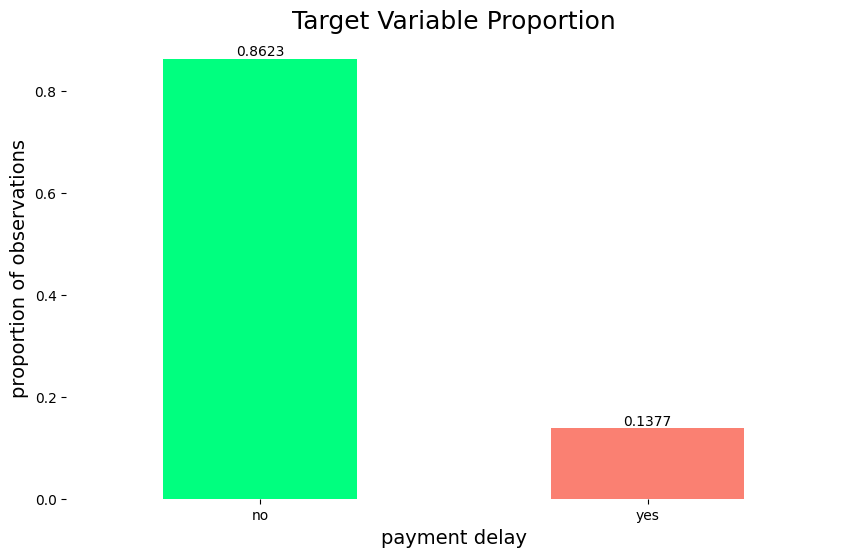

In [181]:
# create a figure
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(111)

# proportion of observation of each class
prop_response = df_telco['payment_delay'].value_counts(normalize=True)

# create a bar plot showing the percentage of churn
bar_plot = prop_response.plot(kind='bar', 
                               ax=ax,
                               color=['springgreen','salmon'])


# annotate each bar with its respective value
for i, value in enumerate(prop_response):
    bar_plot.text(i, value, f'{value:.4f}', ha='center', va='bottom')

# set title and labels
ax.set_title('Target Variable Proportion',
             fontsize=18, loc='center')
ax.set_xlabel('payment delay',
              fontsize=14)
ax.set_ylabel('proportion of observations',
              fontsize=14)
ax.tick_params(rotation='auto')

# eliminate frame
spine_names = ('top', 'right', 'bottom', 'left')
for spine_name in spine_names:
    ax.spines[spine_name].set_visible(False)

INTERPRETATION:
- imbalanced data set (86.23% - no; 13.77% - yes)
- this imbalance might lead to a large number of false negatives (Classifier Bias: Many machine learning algorithms are designed to optimize overall accuracy. In imbalanced datasets, where the majority class dominates, classifiers may prioritize optimizing accuracy by correctly classifying the majority class examples. As a result, they may perform poorly on the minority class, leading to false negatives.
Class Separability: In imbalanced datasets, the minority class may be relatively rare and have less distinct patterns compared to the majority class. This makes it harder for classifiers to correctly identify and separate minority class instances, leading to false negatives.)

### 3.b Plans Information
Stacked percentage bar chart for telecom plans (voice mail & international)

In [182]:
def percentage_stacked_plot(columns_to_plot, super_title):
    
    '''
    Prints a 100% stacked plot of the response variable (payment_delay) for independent variables of the list columns_to_plot.
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=1)
 

    # loop to each column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # calculate the percentage of observations of the response variable for each group of the independent variable
        # 100% stacked bar plot
        prop_by_independent = pd.crosstab(df_telco[column], df_telco['payment_delay']).apply(lambda x: x/x.sum()*100, axis=1)

        prop_by_independent.plot(kind='bar', ax=ax, stacked=True,
                                 rot=0, color=['springgreen','salmon'])
        
        # Add annotations with exact values
        for p in ax.patches:
            width, height = p.get_width(), p.get_height()
            x, y = p.get_xy() 
            ax.annotate(f'{height:.2f}%', (x + width/2, y + height/2), ha='center', va='center')
        

        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),
                  title='Payment Delay', fancybox=True)

        # set title and labels
        ax.set_title('Proportion of observations by ' + column,
                     fontsize=10, loc='center')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)

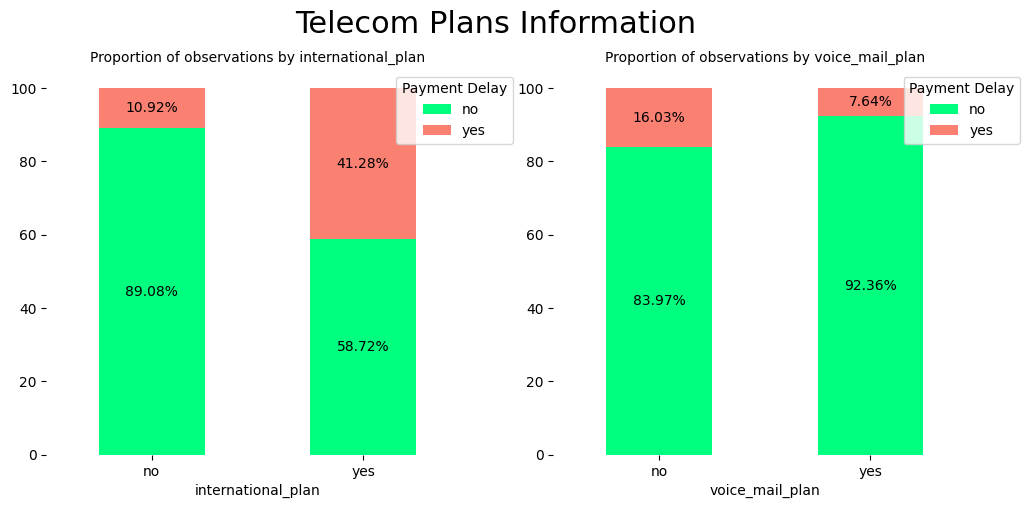

In [183]:
# plans column names
plan_columns = ['international_plan', 'voice_mail_plan']

# stacked plot of demographic columns
percentage_stacked_plot(plan_columns, 'Telecom Plans Information')

INTERPRETATION:
- Observations suggest that users having an international plan have registered aprox 4 times more a payment delay as opposed to users without international plan.
- In contrast, it seems that users having voice mail plan registered 2 times less payment delays vs. users without voice mail plan.

### 3.c Client Usage & Charge - Numerical Variables
We are analysing via the following histogram plots the distribution of minutes, calls and charge for the observed categories in relation to our target variable (payment delay): 
- day 
- evening 
- night
- international

In [184]:
def histogram_plots(columns_to_plot, super_title):
    
    '''
    Prints a histogram for each independent variable of the list columns_to_plot vs. the target variable (payment_delay).
            Parameters:
                    columns_to_plot (list of string): Names of the variables to plot
                    super_title (string): Super title of the visualization
            Returns:
                    None
    '''
    # set number of rows and number of columns
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)

    # create a figure
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=1)
 

    # loop to each demographic column name to create a subplot
    for index, column in enumerate(columns_to_plot, 1):

        # create the subplot
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)

        # histograms for each class (normalized histogram)
        df_telco[df_telco['payment_delay']=='no'][column].plot(kind='hist', ax=ax, density=True, 
                                                       alpha=0.5, color='springgreen', label='No')
        df_telco[df_telco['payment_delay']=='yes'][column].plot(kind='hist', ax=ax, density=True,
                                                        alpha=0.5, color='salmon', label='Yes')
        
        # set the legend in the upper right corner
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5),
                  title='payment delay', fancybox=True)

        # set title and labels
        ax.set_title('Distribution of ' + column,
                     fontsize=16, loc='left')

        ax.tick_params(rotation='auto')

        # eliminate the frame from the plot
        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)
            

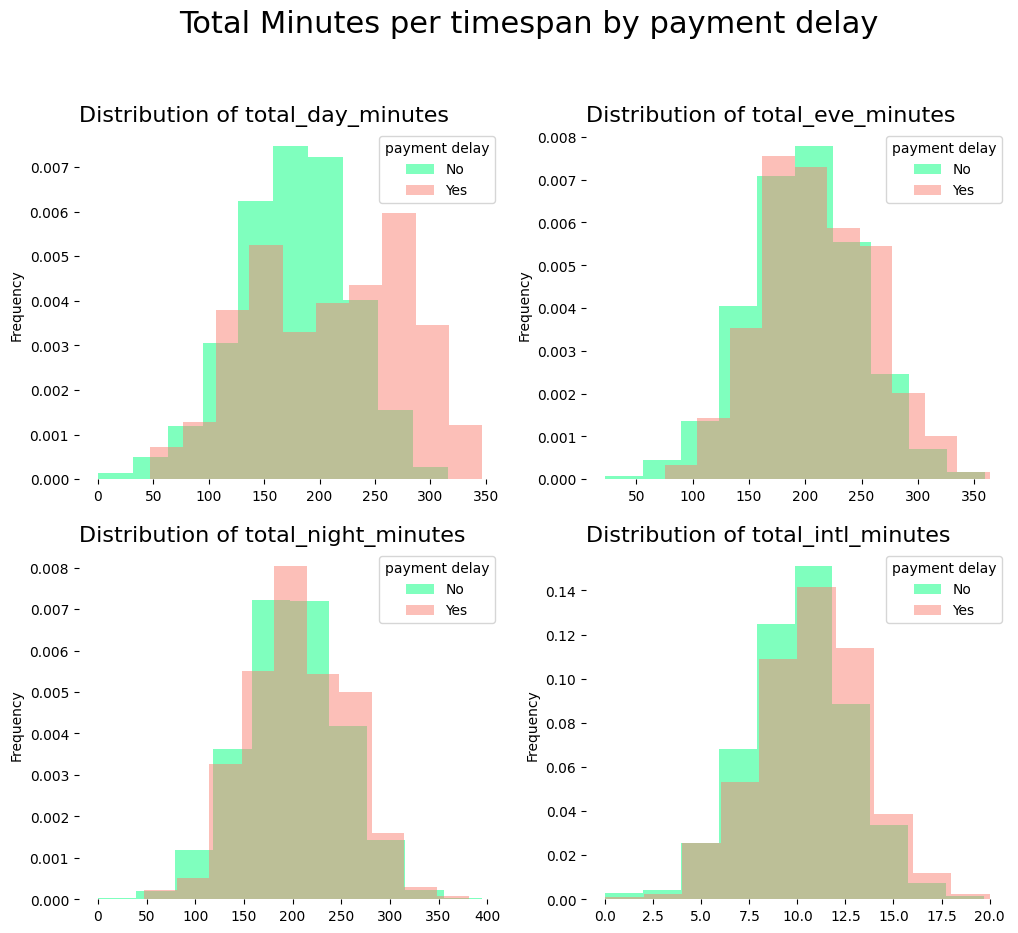

In [185]:
# define columns for analysis
minutes_columns = ['total_day_minutes', 'total_eve_minutes', 'total_night_minutes', 'total_intl_minutes']
# plot histograms 
histogram_plots(minutes_columns, 'Total Minutes per timespan by payment delay')

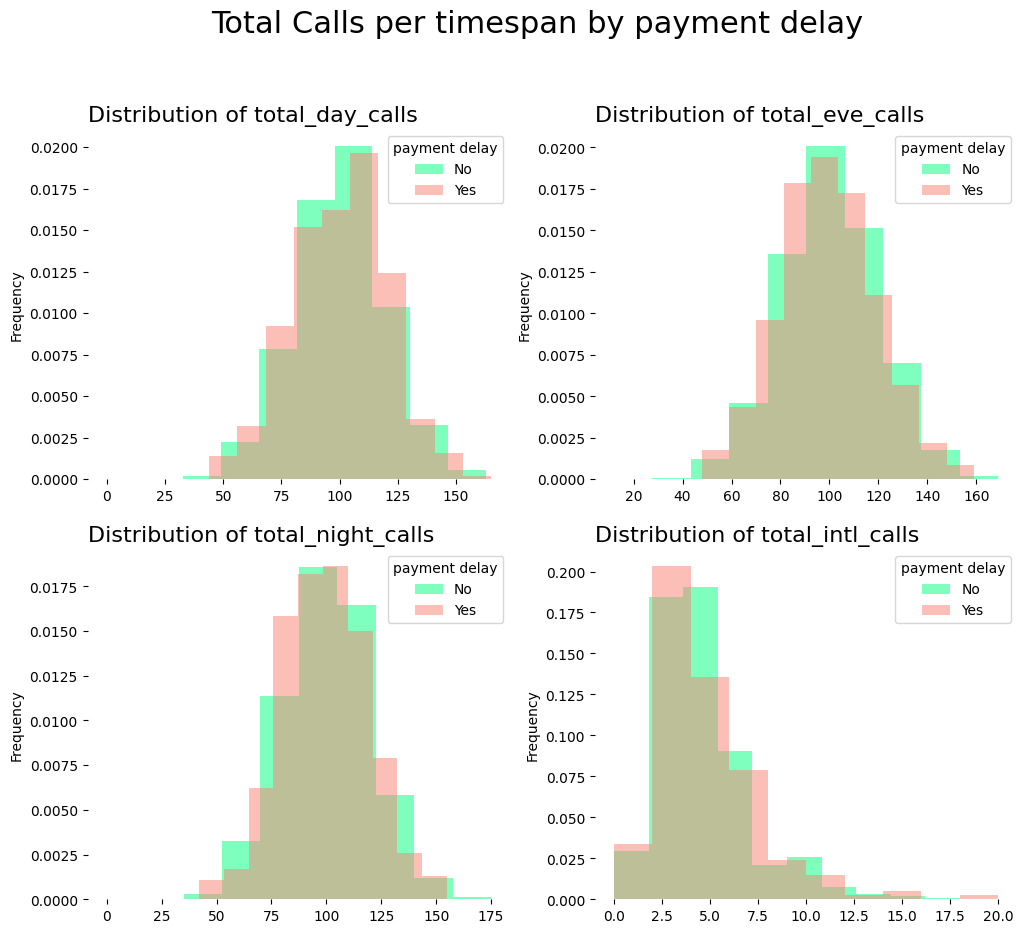

In [186]:
# define columns for analysis
calls_columns = ['total_day_calls', 'total_eve_calls', 'total_night_calls', 'total_intl_calls']
# plot histograms 
histogram_plots(calls_columns, 'Total Calls per timespan by payment delay')

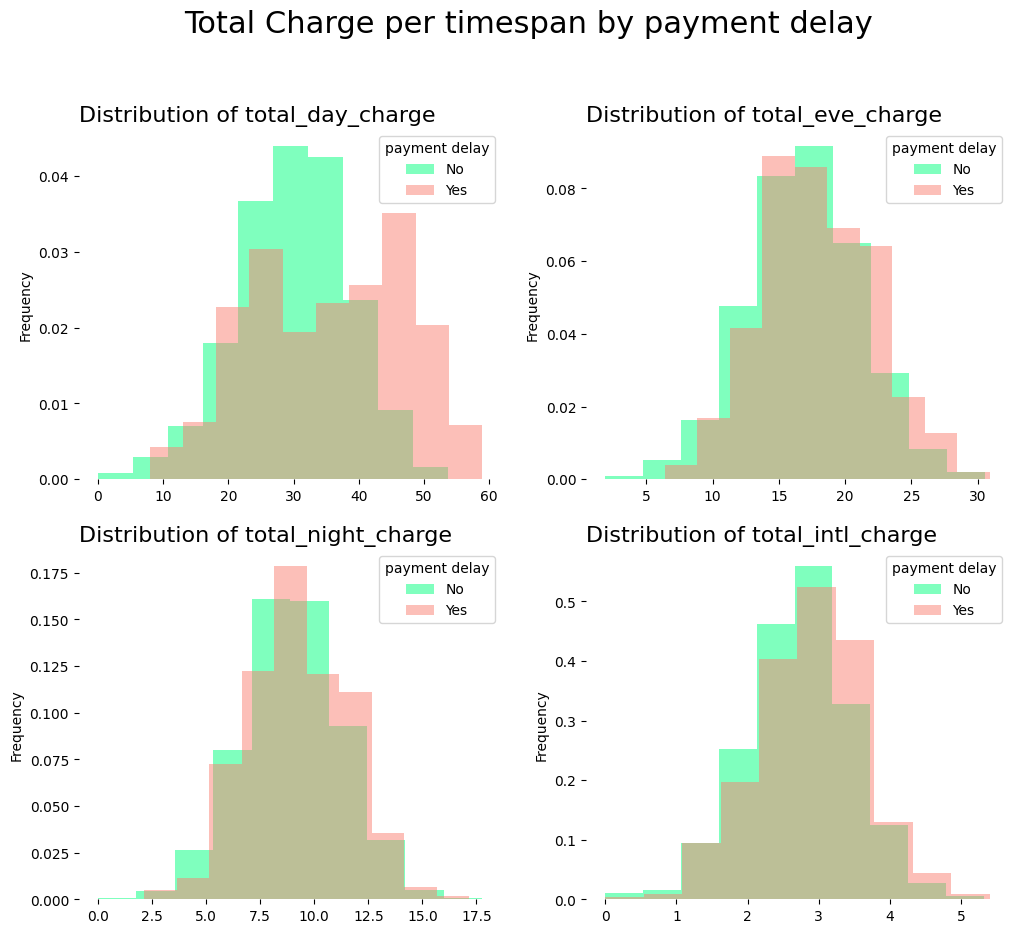

In [187]:
# define columns for analysis
charge_columns = ['total_day_charge', 'total_eve_charge', 'total_night_charge', 'total_intl_charge']
# plot histograms
histogram_plots(charge_columns, 'Total Charge per timespan by payment delay')

INTERPRETATION:
- No substantial correlation observed other than a slightly pronounced payment delay for an increase in service usage (minutes) and charge respectively during daytime (upper left quadrants)

### 3.d Client location (State) Information
- generate a stacked bar plot to visualize the client's residency effects on payment delay 

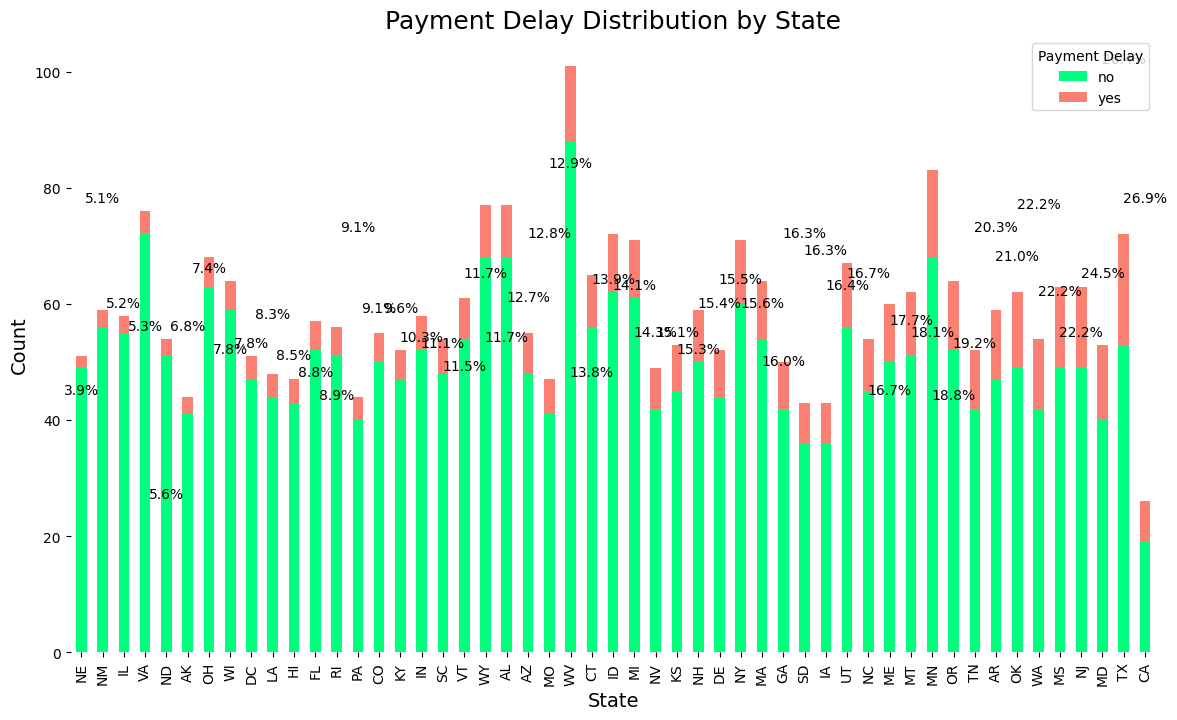

In [188]:

def analyze_payment_delay_by_state(df):
    '''
    Analyze payment_delay regarding client location (state) by generating visualizations.
    
    Parameters:
        df (DataFrame): Input DataFrame containing the data.
        
    Returns:
        None
    '''
    # Group data by state and payment_delay and get counts
    state_payment_delay_counts = df.groupby(['state', 'payment_delay']).size().unstack(fill_value=0)
    
    # Calculate proportion of 'Yes' payment_delay for each state
    state_payment_delay_proportions = state_payment_delay_counts['yes'] / state_payment_delay_counts.sum(axis=1)
    state_payment_delay_proportions.sort_values(inplace=True)
    
    # Plot payment delay distribution for each state
    fig, ax = plt.subplots(figsize=(14, 8))
    state_payment_delay_counts.loc[state_payment_delay_proportions.index].plot(kind='bar', stacked=True, ax=ax, color=['springgreen', 'salmon'], edgecolor='none')
    
    # Annotate each bar with its respective percentage
    for i, value in enumerate(state_payment_delay_proportions):
        ax.text(i, state_payment_delay_counts.iloc[i].sum() + 0.02, f'{value:.1%}', ha='center', va='bottom')

    # Set labels and title
    ax.set_title('Payment Delay Distribution by State', fontsize=18)
    ax.set_xlabel('State', fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax.legend(title='Payment Delay')

    # eliminate the frame from the plot
    spine_names = ('top', 'right', 'bottom', 'left')
    for spine_name in spine_names:
        ax.spines[spine_name].set_visible(False)

    # Show plot
    plt.show()

# Call the function
analyze_payment_delay_by_state(df_telco)


INTERPRETATION:
- significant variability is registered when cosidering client state (regional data)
- at the lower end of the chart, we can observe that NE (Nebraska) or NM (New Mexico) a register a 3.9% and 5.1% payment delay, in contrast to TX (Texas) with 26%, or CA (California) with 26.9%
- the data suggests that larger states, having a significant higher population, a larger market and more economical, cultural & demographical diveristy experience a higher proportion in payment delay.

### 3.e Account Length (tenure) & Service Calls
- Generating histograms to analyze the distribution of account length and number of customer service calls in relation to our target variable (payment delay)

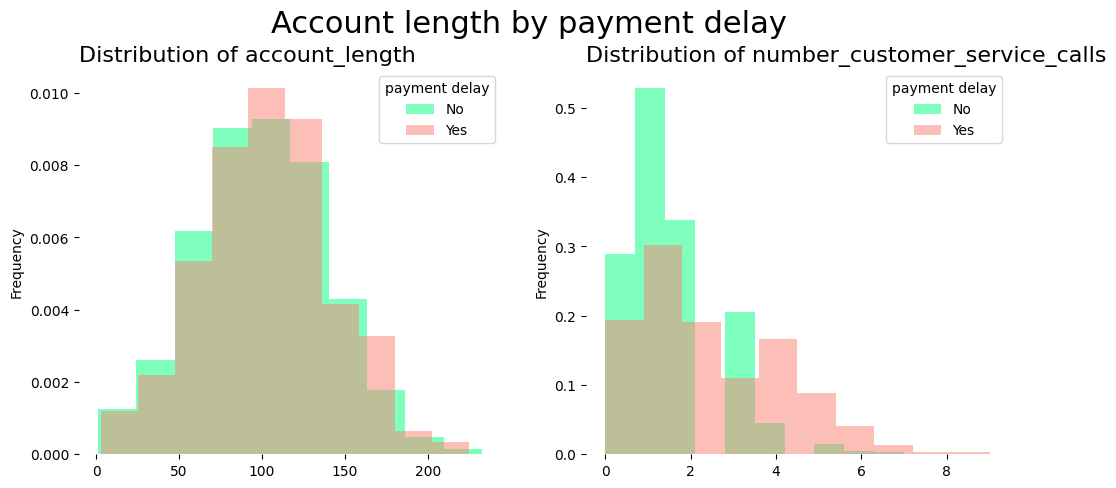

In [189]:
histogram_plots(['account_length', 'number_customer_service_calls'], 'Account length by payment delay')

INTERPRETATION
- Tenure (account length) does not seem to influence the target variable, as the distribution densities seem to overlap
- A slight correlation between increased customer service calls and payment delays is observed.

## 4. Feature Importance (non numerical)

### Mutual information — analysis of linear and nonlinear relationships

Mutual information measures the mutual dependency between two variables based on entropy estimations. In machine learning, we are interested in evaluating the degree of dependency between each independent variable and the response variable. Higher values of mutual information show a higher degree of dependency which indicates that the independent variable will be useful for predicting the target.

The Scikit-Learn library has implemented mutual information in the metrics package. The following code computes the mutual information score between each categorical variable of the data set and the target variable.

In [190]:
# function that computes the mutual infomation score between a categorical serie and the column payment_delay
def compute_mutual_information(categorical_serie):
    return mutual_info_score(categorical_serie, df_telco['payment_delay'])

# select categorial variables excluding the response variable 
# categorical_variables = df_telco.select_dtypes(include=object).drop('Churn', axis=1)
categorical_variables = df_telco[['international_plan', 'voice_mail_plan', 'state']]

# compute the mutual information score between each categorical variable and the target
feature_importance = categorical_variables.apply(compute_mutual_information).sort_values(ascending=False)

# visualize feature importance
print(feature_importance)

international_plan    0.024613
state                 0.013241
voice_mail_plan       0.006480
dtype: float64


INTERPRETATION:
- we can observe that international_plan and state information have a stronger relation to the target as opposed to voice_mail_plan.

## 5. Feature Engineering / Data Prep
- Feature engineering is the process of extracting features from the data and transforming them into a format that is suitable for the machine learning model.
- Most machine learning algorithms require numerical values; therefore, all categorical attributes available in the dataset should be encoded into numerical labels before training the model. In addition, we need to transform numeric columns into a common scale. This will prevent that the columns with large values dominate the learning process.

### 5.a Label Encoding
Label encoding is used to replace categorical values with numerical values. This encoding replaces every category with a numerical label. Binary variables for our customer plans are replaced below.

In [191]:
df_telco_prep = df_telco.copy()

# label encoding (binary variables)
label_encoding_columns = ['international_plan', 'voice_mail_plan', 'payment_delay']

# encode categorical binary features using label encoding
for column in label_encoding_columns:
    df_telco_prep[column] = df_telco_prep[column].map({'yes': 1, 'no': 0})

df_telco_prep


,state,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,payment_delay
0,HI,33,0,0,0,200.5,117,34.09,159.9,111,13.59,196.2,84,8.83,16.3,6,4.40,3,0
1,TN,80,1,0,0,276.5,122,47.01,195.6,79,16.63,210.3,78,9.46,7.2,3,1.94,1,1
2,CT,37,0,0,0,134.9,98,22.93,248.4,130,21.11,236.2,113,10.63,14.7,2,3.97,3,0
3,TN,106,0,0,0,119.2,142,20.26,228.4,139,19.41,197.9,61,8.91,8.4,9,2.27,2,0
4,TX,123,0,0,0,260.9,85,44.35,168.5,103,14.32,178.3,91,8.02,13.3,5,3.59,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,MT,10,0,0,0,183.0,103,31.11,214.8,77,18.26,206.4,73,9.29,8.7,6,2.35,2,0
2996,OR,135,0,0,0,263.8,66,44.85,251.3,116,21.36,200.1,112,9.00,8.4,2,2.27,5,1
2997,AK,52,0,0,0,148.3,83,25.21,181.6,79,15.44,155.6,104,7.00,8.3,6,2.24,3,0
2998,TN,39,0,0,0,187.2,110,31.82,114.7,116,9.75,104.7,83,4.71,13.2,5,3.56,1,0


### 5.b Target Encoding (Mean Encoding)
Helps capture the relationship between the categories and the target variable by encoding each category with the mean of the target variable for that category. This technique can work well for classification problems, especially when there's a strong correlation between the categorical variable and the target variable.
We will implement target encoding for the 'state' variable.

In [192]:
# 1. Split the DataFrame into features (X) and target variable (y)
X = df_telco_prep.drop(columns=['payment_delay'])  # Features
y = df_telco_prep['payment_delay']  # Target variable

# 2. Initialize the TargetEncoder
encoder = TargetEncoder(cols=['state'])

unique_states = df_telco_prep['state'].unique()

# 3. Fit and transform the 'state' column using target encoding
X['state_encoded'] = encoder.fit_transform(X['state'], y)

# 4. Drop the original 'state' column
X.drop(columns=['state'], inplace=True)

# Now, df_telco_prep = X, & contains the target-encoded 'state' column as 'state_encoded'
df_telco_prep = X.copy(deep=True)
df_telco_prep['payment_delay'] = y
df_telco_prep




,account_length,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,number_customer_service_calls,state_encoded,payment_delay
0,33,0,0,0,200.5,117,34.09,159.9,111,13.59,196.2,84,8.83,16.3,6,4.40,3,0.088416,0
1,80,1,0,0,276.5,122,47.01,195.6,79,16.63,210.3,78,9.46,7.2,3,1.94,1,0.190168,1
2,37,0,0,0,134.9,98,22.93,248.4,130,21.11,236.2,113,10.63,14.7,2,3.97,3,0.138453,0
3,106,0,0,0,119.2,142,20.26,228.4,139,19.41,197.9,61,8.91,8.4,9,2.27,2,0.190168,0
4,123,0,0,0,260.9,85,44.35,168.5,103,14.32,178.3,91,8.02,13.3,5,3.59,3,0.263196,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,10,0,0,0,183.0,103,31.11,214.8,77,18.26,206.4,73,9.29,8.7,6,2.35,2,0.176832,0
2996,135,0,0,0,263.8,66,44.85,251.3,116,21.36,200.1,112,9.00,8.4,2,2.27,5,0.186896,1
2997,52,0,0,0,148.3,83,25.21,181.6,79,15.44,155.6,104,7.00,8.3,6,2.24,3,0.073961,0
2998,39,0,0,0,187.2,110,31.82,114.7,116,9.75,104.7,83,4.71,13.2,5,3.56,1,0.190168,0


In [193]:
# Create a dictionary mapping state names to their encoded values
state_encoding_dict = dict(zip(unique_states, X['state_encoded'].unique()))

import pprint
pprint.pprint(state_encoding_dict)

{'AL': 0.11695242601680905,
 'AR': 0.16573009819041157,
 'AZ': 0.11512763049106259,
 'CO': 0.078847147233022,
 'CT': 0.13845280525072953,
 'DC': 0.18064397213492986,
 'DE': 0.11196873511810329,
 'FL': 0.0864479468905052,
 'GA': 0.04345963778547438,
 'HI': 0.088416280437861,
 'ID': 0.08098484347405924,
 'IL': 0.05360466968723503,
 'IN': 0.08892437947326498,
 'KS': 0.1504711271663237,
 'KY': 0.05256997727805406,
 'LA': 0.2194914612627199,
 'MA': 0.09057250216543314,
 'MD': 0.15602461324987557,
 'ME': 0.127577396822658,
 'MI': 0.14082580992671456,
 'MN': 0.17683204736376312,
 'MO': 0.12828975464820155,
 'MS': 0.22109028394812744,
 'MT': 0.2086135302123672,
 'NC': 0.09777972577456312,
 'ND': 0.16614506657776598,
 'NE': 0.05820737204579499,
 'NH': 0.2414549772349429,
 'NJ': 0.13888218341245623,
 'NM': 0.22261185916011683,
 'NV': 0.0740529366714115,
 'NY': 0.15482496765218517,
 'OH': 0.16050132157636318,
 'OK': 0.15894082216570102,
 'OR': 0.1425864410297358,
 'PA': 0.07396106039577466,
 'RI'

## 6. Correlation Analysis
- Correlation analysis is a statistical technique used to measure the strength and direction of the relationship between two quantitative variables. It helps in understanding how changes in one variable are associated with changes in another variable.

### 6.a Correlation Matrix for Target Variables:

In [194]:
# Compute correlation matrix for target variables
target_corr_matrix = df_telco_prep.corrwith(df_telco_prep['payment_delay']).sort_values(ascending=False)

# Print correlation matrix for target variables
print("Correlation Matrix for Target Variables:")
print(target_corr_matrix)

Correlation Matrix for Target Variables:
payment_delay                    1.000000
international_plan               0.256719
total_day_minutes                0.215140
total_day_charge                 0.215136
number_customer_service_calls    0.202188
state_encoded                    0.160229
total_eve_minutes                0.088606
total_eve_charge                 0.088584
total_intl_charge                0.069286
total_intl_minutes               0.069259
total_night_minutes              0.041503
total_night_charge               0.041498
account_length                   0.032944
total_day_calls                 -0.002518
total_night_calls               -0.007285
total_eve_calls                 -0.011318
total_intl_calls                -0.033655
number_vmail_messages           -0.097651
voice_mail_plan                 -0.108147
dtype: float64


INTERPRETAION:
- each correlation coefficient is indicating the strength and direction of the linear relationship between payment_delay and the other variables. Positive coefficients suggest a positive relationship, negative coefficients suggest a negative relationship, and coefficients close to 0 suggest little to no linear relationship.
- relevant variables are thus:
    - payment_delay                    
    - international_plan              
    - total_day_minutes                
    - total_day_charge                 
    - number_customer_service_calls    
    - state_encoded
- considering all previous analysis(Data Visualization chapter also) and previous output, we can remove the other irrelevant features:

In [195]:
df_telco_prep.drop(columns=['total_eve_minutes','total_eve_charge','total_intl_charge','total_intl_minutes','total_night_minutes','total_night_charge','account_length','total_day_calls','total_night_calls','total_eve_calls','total_intl_calls'], inplace=True)
df_telco_prep

,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_charge,number_customer_service_calls,state_encoded,payment_delay
0,0,0,0,200.5,34.09,3,0.088416,0
1,1,0,0,276.5,47.01,1,0.190168,1
2,0,0,0,134.9,22.93,3,0.138453,0
3,0,0,0,119.2,20.26,2,0.190168,0
4,0,0,0,260.9,44.35,3,0.263196,0
...,...,...,...,...,...,...,...,...
2995,0,0,0,183.0,31.11,2,0.176832,0
2996,0,0,0,263.8,44.85,5,0.186896,1
2997,0,0,0,148.3,25.21,3,0.073961,0
2998,0,0,0,187.2,31.82,1,0.190168,0


### 6.b Correlation Matrix between Features:

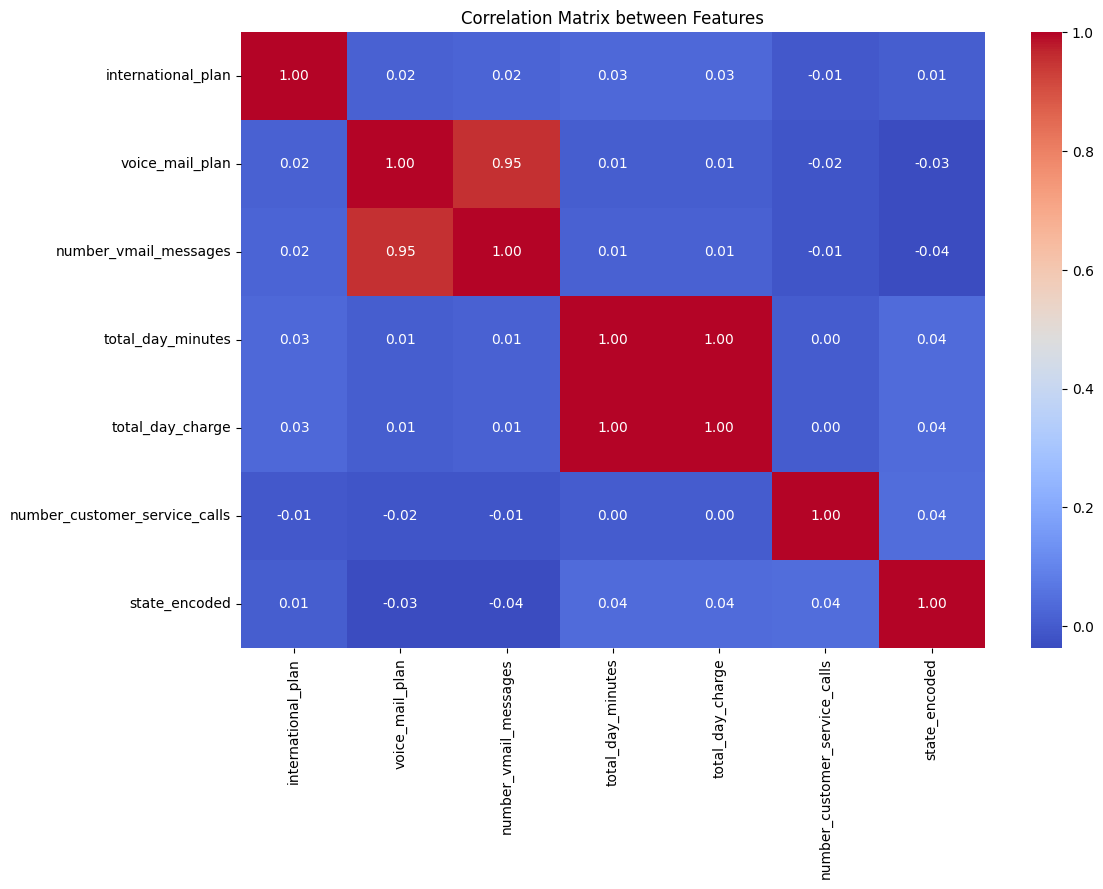

In [196]:
# Compute correlation matrix for features
feature_corr_matrix = df_telco_prep.drop(columns=['payment_delay']).corr()

# Plot correlation matrix as heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(feature_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix between Features')
plt.show()

INTERPRETATION:
- Total day minutes and charge are again seen as correlated and one of them can be droped.
- Number of vmail messages with vmail plan is also strongly correlated and we can drop the vmail messages.

In [197]:
df_telco_prep.drop(columns=['total_day_minutes', 'number_vmail_messages'], inplace=True)
df_telco_prep

,international_plan,voice_mail_plan,total_day_charge,number_customer_service_calls,state_encoded,payment_delay
0,0,0,34.09,3,0.088416,0
1,1,0,47.01,1,0.190168,1
2,0,0,22.93,3,0.138453,0
3,0,0,20.26,2,0.190168,0
4,0,0,44.35,3,0.263196,0
...,...,...,...,...,...,...
2995,0,0,31.11,2,0.176832,0
2996,0,0,44.85,5,0.186896,1
2997,0,0,25.21,3,0.073961,0
2998,0,0,31.82,1,0.190168,0


# ML Model Building
## A) Data Preprocessing - Normalization
Data Normalization is a common practice in machine learning which consists of transforming numeric columns to a common scale. In machine learning, some feature values differ from others multiple times. The features with higher values will dominate the learning process; however, it does not mean those variables are more important to predict the target. Data normalization transforms multiscaled data to the same scale. After normalization, all variables have a similar influence on the model, improving the stability and performance of the learning algorithm.

In [198]:
# min-max normalization (numeric variables)
min_max_columns = ['total_day_charge', 'number_customer_service_calls']

# scale numerical variables using min max scaler
for column in min_max_columns:
        # minimum value of the column
        min_column = df_telco_prep[column].min()
        # maximum value of the column
        max_column = df_telco_prep[column].max()
        # min max scaler
        df_telco_prep[column] = (df_telco_prep[column] - min_column) / (max_column - min_column)

df_telco_prep

,international_plan,voice_mail_plan,total_day_charge,number_customer_service_calls,state_encoded,payment_delay
0,0,0,0.578189,0.333333,0.088416,0
1,1,0,0.797320,0.111111,0.190168,1
2,0,0,0.388908,0.333333,0.138453,0
3,0,0,0.343623,0.222222,0.190168,0
4,0,0,0.752205,0.333333,0.263196,0
...,...,...,...,...,...,...
2995,0,0,0.527646,0.222222,0.176832,0
2996,0,0,0.760685,0.555556,0.186896,1
2997,0,0,0.427578,0.333333,0.073961,0
2998,0,0,0.539688,0.111111,0.190168,0


## B) Train-Test Split

In [199]:

# X is the feature matrix and y is the target variable
X = df_telco_prep.drop(columns='payment_delay').copy(deep=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print("X_train:")
print(X_train.shape)
X_train.info()
print("-------------------------")

print("X_test:")
print(X_test.shape)
X_test.info()
print("-------------------------")

print("y_train:")
print(y_train.shape)
y_train.info()
print("-------------------------")

print("y_test:")
print(y_test.shape)
y_test.info()

X_train:
(2400, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 672 to 1237
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   international_plan             2400 non-null   int64  
 1   voice_mail_plan                2400 non-null   int64  
 2   total_day_charge               2400 non-null   float64
 3   number_customer_service_calls  2400 non-null   float64
 4   state_encoded                  2400 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 112.5 KB
-------------------------
X_test:
(600, 5)
<class 'pandas.core.frame.DataFrame'>
Index: 600 entries, 1300 to 460
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   international_plan             600 non-null    int64  
 1   voice_mail_plan                600 non-null    int64  
 2   total_day_charge

## C) Model Selection

In [200]:
def create_models(seed=2):
    '''
    Create a list of machine learning models.
            Parameters:
                    seed (integer): random seed of the models
            Returns:
                    models (list): list containing the models
    '''

    models = []
    models.append(('dummy_classifier', DummyClassifier(random_state=seed, strategy='most_frequent')))
    models.append(('k_nearest_neighbors', KNeighborsClassifier()))
    models.append(('logistic_regression', LogisticRegression(random_state=seed)))
    models.append(('support_vector_machines', SVC(random_state=seed)))
    models.append(('random_forest', RandomForestClassifier(random_state=seed)))
    models.append(('gradient_boosting', GradientBoostingClassifier(random_state=seed)))
    
    return models

# create a list with all the algorithms we are going to assess
models = create_models()
models

[('dummy_classifier',
  DummyClassifier(random_state=2, strategy='most_frequent')),
 ('k_nearest_neighbors', KNeighborsClassifier()),
 ('logistic_regression', LogisticRegression(random_state=2)),
 ('support_vector_machines', SVC(random_state=2)),
 ('random_forest', RandomForestClassifier(random_state=2)),
 ('gradient_boosting', GradientBoostingClassifier(random_state=2))]

Matthews Correlation Coefficient (MCC) is a metric that can be useful, especially for imbalanced datasets. MCC takes into account all four values of the confusion matrix (true positives, true negatives, false positives, false negatives) and is particularly helpful when the classes are imbalanced.

MCC ranges from -1 to 1, where 1 indicates perfect prediction, 0 indicates random prediction, and -1 indicates total disagreement between prediction and observation.

In [201]:
from sklearn.metrics import matthews_corrcoef

# test the accuracy of each model using default hyperparameters
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    # fit the model with the training data
    model.fit(X_train, y_train).predict(X_test)
    # make predictions with the testing data
    predictions = model.predict(X_test)
    # calculate accuracy 
    # accuracy = accuracy_score(y_test, predictions)

    accuracy = matthews_corrcoef(y_test, predictions)

    # append the model name and the accuracy to the lists
    results.append(accuracy)
    names.append(name)
    # print classifier accuracy
    print('Classifier: {}, Accuracy: {})'.format(name, accuracy))

Classifier: dummy_classifier, Accuracy: 0.0)
Classifier: k_nearest_neighbors, Accuracy: 0.5586315156715145)
Classifier: logistic_regression, Accuracy: 0.2691223117519896)
Classifier: support_vector_machines, Accuracy: 0.4835271700641705)
Classifier: random_forest, Accuracy: 0.5084425100209666)
Classifier: gradient_boosting, Accuracy: 0.5679905285705968)


#### Selected Algorithm => Random Forest 
(Remark: Even though lower than others, seems to output a good accuracy after hyperparameter tuning.)
- An ensemble learning method based on decision trees. It trains multiple decision trees on random subsets of the data and features, then aggregates their predictions to make final predictions. It's known for its robustness, ability to handle large datasets, and feature importance ranking.

## D) Hyperparameter tuning - Improving Accuracy

In [202]:
from sklearn.metrics import make_scorer, matthews_corrcoef
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the MCC scorer
mcc_scorer = make_scorer(matthews_corrcoef)

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],   # Minimum number of samples required to split a node
    'min_samples_leaf': [1, 2, 4]      # Minimum number of samples required at each leaf node
}

# Initialize the Random Forest classifier
rf = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV with MCC as the scoring metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=mcc_scorer, n_jobs=-1)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Evaluate the best model on the test set
test_mcc = matthews_corrcoef(y_test, best_rf.predict(X_test))
print("Test MCC precision after hyperparameter tuning:")
print("MCC precision score (scale -1 to 1):", test_mcc)
mcc_score_scaled = (test_mcc + 1) / 2
print("Precision score (normal scale 0-1):", mcc_score_scaled)

Best Parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Test MCC precision after hyperparameter tuning:
MCC precision score (scale -1 to 1): 0.5936121986591524
Precision score (normal scale 0-1): 0.7968060993295762


## E) Performance of the model

In [203]:
from sklearn.metrics import confusion_matrix

# make the predictions
random_search_predictions = best_rf.predict(X_test)

# construct the confusion matrix
confusion_matrix = confusion_matrix(y_test, random_search_predictions)

# visualize the confusion matrix
confusion_matrix

array([[509,   8],
       [ 43,  40]])

## F) Prediction Demo

In [204]:
# # Prediction Demo
new_data_json = {
  "state": ["TN"],
  "account_length": [80],
  "area_code": ["area_code_415"],
  "international_plan": ["yes"],
  "voice_mail_plan": ["no"],
  "number_vmail_messages": [0],
  "total_day_minutes": [276.5],
  "total_day_calls": [122],
  "total_day_charge": [47.01],
  "total_eve_minutes": [195.6],
  "total_eve_calls": [79],
  "total_eve_charge": [16.63],
  "total_night_minutes": [210.3],
  "total_night_calls": [78],
  "total_night_charge": [9.46],
  "total_intl_minutes": [7.2],
  "total_intl_calls": [3],
  "total_intl_charge": [1.94],
  "number_customer_service_calls": [1],
}


df_new_data = pd.DataFrame(new_data_json)

def encode_new_data(data):
    encoded_data = data.copy()

    # drop unused columns
    columns_to_drop = ['area_code', 'total_day_minutes', 'total_eve_minutes','total_eve_charge','total_intl_charge','total_intl_minutes','total_night_minutes','total_night_charge','account_length','total_day_calls','total_night_calls','total_eve_calls','total_intl_calls','number_vmail_messages']
    for column in encoded_data.columns.tolist():
        if column in columns_to_drop:
            encoded_data.drop(columns=column, inplace=True)
   
    # label encoding (binary variables)
    label_encoding_columns = ['international_plan', 'voice_mail_plan']
    for column in label_encoding_columns:
        encoded_data[column] = encoded_data[column].map({'yes': 1, 'no': 0})

    # map state categorical value to its numerical mean encoding
    global state_encoding_dict
    state_name = encoded_data.at[0, 'state']
    encoded_data.drop(columns=['state'], inplace=True)
    encoded_data.loc[0, 'state_encoded'] = state_encoding_dict[state_name]

    return encoded_data


df_encoded_new_data = encode_new_data(df_new_data)
print(df_encoded_new_data)

payment_delay_prediction = best_rf.predict(df_encoded_new_data)
print(type(payment_delay_prediction))

if any(payment_delay_prediction) == 1:
    print("Client Payment Delay Prediction: True")
else:
    print("Client Payment Delay Prediction: False")


# Print the precision score
print("Precision Score:", mcc_score_scaled)

   international_plan  voice_mail_plan  total_day_charge  \
0                   1                0             47.01   

   number_customer_service_calls  state_encoded  
0                              1       0.190168  
<class 'numpy.ndarray'>
Client Payment Delay Prediction: True
Precision Score: 0.7968060993295762


## G) Export the Model

In [205]:
import pickle

with open('best_rf_model.pkl', 'wb') as file:
    pickle.dump(best_rf, file)